# "Прогнозирование оставшегося срока службы (RUL) оборудования по данным телеметрии  методами машинного обучения на примере турбореактивного двигателя" - экспериментальная часть

## 1. Импорт библиотек

In [28]:
import numpy as np
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from sklearn.metrics import r2_score
from keras import models, layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

## 2. Вспомогательные функции

In [29]:
def loadData():
    dirPath = '/kaggle/input/nasa-cmaps/CMaps/'
    trainTxtFile = 'train_FD001.txt'
    testTxtFile = 'test_FD001.txt'
    rulTxtFile = 'RUL_FD001.txt'
    
    trainTestColumns = ['Номер изделия', 'Время в циклах',
           'Опер. настройка 1', 'Опер. настройка 2', 'Опер. настройка 3',
           'Изм. 1', 'Изм. 2', 'Изм. 3', 'Изм. 4', 'Изм. 5', 'Изм. 6', 'Изм. 7', 
           'Изм. 8', 'Изм. 9', 'Изм. 10', 'Изм. 11', 'Изм. 12', 'Изм. 13', 'Изм. 14', 
           'Изм. 15', 'Изм. 16', 'Изм. 17', 'Изм. 18', 'Изм. 19',
           'Изм. 20', 'Изм. 21']
    
    trainDataset = None
    testDataset = None
    expectedRulDataset = None
    
    tempTrain = pd.read_csv( dirPath + trainTxtFile, sep = " ", header = None)
    tempTest = pd.read_csv( dirPath + testTxtFile, sep = " ", header = None)
    tempRul = pd.read_csv( dirPath + rulTxtFile, sep = " ", header = None)

    tempTrain.drop(inplace = True, columns = [26, 27])
    tempTest.drop(inplace = True, columns = [26, 27])
    tempRul.drop(inplace = True, columns = [1])

    tempTrain.columns = tempTest.columns = trainTestColumns
    tempRul.columns = ["Expected RUL"]

    trainDataset = tempTrain
    testDataset = tempTest
    expectedRulDataset = tempRul
    
    return trainDataset, testDataset, expectedRulDataset

In [30]:
def checkBasicStructure(trainDataset, testDataset, expectedRulDataset):
    print("\nTrain Dataset")
    display(trainDataset.head())

    print("\nTest Dataset")
    display(testDataset.head())

    print("\nExpected RUL")
    display(expectedRulDataset.head())
    print("\n")

In [31]:
def checkForNA(trainDataset, testDataset, expectedRulDataset):
    print("\nTrain Dataset")
    display(trainDataset.isna().sum())

    print("\nTest Dataset")
    display(testDataset.isna().sum())

    print("\nExpected RUL")
    display(expectedRulDataset.isna().sum())
    print("\n")

In [32]:
def findRul(dataset):
    temp = copy.deepcopy(dataset.iloc[:, 0:2])
    tempRul = temp.groupby(dataset.columns[0])[dataset.columns[1]].max()
    tempRul = pd.DataFrame(tempRul)
    tempRul.columns = ["Max"]
    tempRul = pd.merge(temp, tempRul, left_on = dataset.columns[0], right_on = dataset.columns[0])
    tempRul["RUL"] = tempRul["Max"] - tempRul[dataset.columns[1]];
    tempRul.drop(inplace = True, columns = ["Max", dataset.columns[1]])

    return tempRul

In [33]:
def checkRulBasicStructure(rulDataset):
    print("\nExpected RUL")
    display(rulDataset.head())
    print("\n")

In [34]:
def processTrainingData(dataset, rulDataset = None, window = 1, shift = 1):
    partitions = int(np.floor((len(dataset) - window) / shift)) + 1
    features = dataset.shape[1]

    processedData = np.repeat(np.nan, repeats = partitions * window * features).reshape(partitions, window, features)

    if rulDataset is None:
        for i in range(partitions):
            processedData[i, :, :] = dataset[(0 + shift * i): (0 + shift * i + window), :]
            
        return processedData

    processedRul = np.repeat(np.nan, repeats = partitions)
    for i in range(partitions):
        processedData[i, :, :] = dataset[(0 + shift * i): (0 + shift * i + window), :]
        processedRul[i] = rulDataset[(shift * i + (window - 1))]

    return processedData, processedRul

In [35]:
def processTestingData(dataset, window, shift, testWindow = 1):
    maxPartitions = int(np.floor((len(dataset) - window) / shift)) + 1

    if maxPartitions < testWindow:
        newLen = (maxPartitions - 1) * shift + window

        processedData = processTrainingData(dataset[-newLen:, :] , window = window, shift = shift)

        return processedData, maxPartitions

    newLen = (testWindow - 1) * shift + window

    processedData = processTrainingData(dataset[-newLen:, :] , window = window, shift = shift)

    return processedData, testWindow

In [83]:
def createModel(shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(shape[1], shape[2])))
    model.add(LSTM(64, return_sequences = True))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

    return model

## 3. Подгрузка данных

In [37]:
trainDataset, testDataset, expectedRulDataset = loadData()

Базово проверим струтуру данных

In [38]:
checkBasicStructure(trainDataset, testDataset, expectedRulDataset)


Train Dataset


,Номер изделия,Время в циклах,Опер. настройка 1,Опер. настройка 2,Опер. настройка 3,Изм. 1,Изм. 2,Изм. 3,Изм. 4,Изм. 5,...,Изм. 12,Изм. 13,Изм. 14,Изм. 15,Изм. 16,Изм. 17,Изм. 18,Изм. 19,Изм. 20,Изм. 21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044



Test Dataset


,Номер изделия,Время в циклах,Опер. настройка 1,Опер. настройка 2,Опер. настройка 3,Изм. 1,Изм. 2,Изм. 3,Изм. 4,Изм. 5,...,Изм. 12,Изм. 13,Изм. 14,Изм. 15,Изм. 16,Изм. 17,Изм. 18,Изм. 19,Изм. 20,Изм. 21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130



Expected RUL


,Expected RUL
0,112
1,98
2,69
3,82
4,91


Проверим на наличие пропущенных значений

In [39]:
checkForNA(trainDataset, testDataset, expectedRulDataset)


Train Dataset


Номер изделия        0
Время в циклах       0
Опер. настройка 1    0
Опер. настройка 2    0
Опер. настройка 3    0
Изм. 1               0
Изм. 2               0
Изм. 3               0
Изм. 4               0
Изм. 5               0
Изм. 6               0
Изм. 7               0
Изм. 8               0
Изм. 9               0
Изм. 10              0
Изм. 11              0
Изм. 12              0
Изм. 13              0
Изм. 14              0
Изм. 15              0
Изм. 16              0
Изм. 17              0
Изм. 18              0
Изм. 19              0
Изм. 20              0
Изм. 21              0
dtype: int64


Test Dataset


Номер изделия        0
Время в циклах       0
Опер. настройка 1    0
Опер. настройка 2    0
Опер. настройка 3    0
Изм. 1               0
Изм. 2               0
Изм. 3               0
Изм. 4               0
Изм. 5               0
Изм. 6               0
Изм. 7               0
Изм. 8               0
Изм. 9               0
Изм. 10              0
Изм. 11              0
Изм. 12              0
Изм. 13              0
Изм. 14              0
Изм. 15              0
Изм. 16              0
Изм. 17              0
Изм. 18              0
Изм. 19              0
Изм. 20              0
Изм. 21              0
dtype: int64


Expected RUL


Expected RUL    0
dtype: int64

Удалим лишние колонки (с константным/околоконстантным значением)

In [40]:
trainDataset.drop(columns=['Опер. настройка 3', 'Изм. 1', 'Изм. 5', 'Изм. 10', 'Изм. 16', 'Изм. 18', 'Изм. 19'], inplace=True)
testDataset.drop(columns=['Опер. настройка 3', 'Изм. 1', 'Изм. 5', 'Изм. 10', 'Изм. 16', 'Изм. 18', 'Изм. 19'], inplace=True)

## 4. Препроцессинг

In [41]:
trainDatasetCopy = copy.deepcopy(trainDataset)
testDatasetCopy = copy.deepcopy(testDataset)
expectedRulDatasetCopy = copy.deepcopy(expectedRulDataset)

Отнормируем все признаки

In [42]:
scaler = StandardScaler()

In [43]:
trainDatasetCopy.iloc[:, 2:] = scaler.fit_transform(trainDatasetCopy.iloc[:, 2:])
testDatasetCopy.iloc[:, 2: ] = scaler.transform(testDatasetCopy.iloc[:, 2:])

Посмотрим на данные после нормировки

In [44]:
checkBasicStructure(trainDatasetCopy, testDatasetCopy, expectedRulDatasetCopy)


Train Dataset


,Номер изделия,Время в циклах,Опер. настройка 1,Опер. настройка 2,Изм. 2,Изм. 3,Изм. 4,Изм. 6,Изм. 7,Изм. 8,Изм. 9,Изм. 11,Изм. 12,Изм. 13,Изм. 14,Изм. 15,Изм. 17,Изм. 20,Изм. 21
0,1,1,-0.315980,-1.372953,-1.721725,-0.134255,-0.925936,0.141683,1.121141,-0.516338,-0.862813,-0.266467,0.334262,-1.058890,-0.269071,-0.603816,-0.781710,1.348493,1.194427
1,1,2,0.872722,-1.031720,-1.061780,0.211528,-0.643726,0.141683,0.431930,-0.798093,-0.958818,-0.191583,1.174899,-0.363646,-0.642845,-0.275852,-0.781710,1.016528,1.236922
2,1,3,-1.961874,1.015677,-0.661813,-0.413166,-0.525953,0.141683,1.008155,-0.234584,-0.557139,-1.015303,1.364721,-0.919841,-0.551629,-0.649144,-2.073094,0.739891,0.503423
3,1,4,0.324090,-0.008022,-0.661813,-1.261314,-0.784831,0.141683,1.222827,0.188048,-0.713826,-1.539489,1.961302,-0.224597,-0.520176,-1.971665,-0.781710,0.352598,0.777792
4,1,5,-0.864611,-0.690488,-0.621816,-1.251528,-0.301518,0.141683,0.714393,-0.516338,-0.457059,-0.977861,1.052871,-0.780793,-0.521748,-0.339845,-0.136018,0.463253,1.059552



Test Dataset


,Номер изделия,Время в циклах,Опер. настройка 1,Опер. настройка 2,Изм. 2,Изм. 3,Изм. 4,Изм. 6,Изм. 7,Изм. 8,Изм. 9,Изм. 11,Изм. 12,Изм. 13,Изм. 14,Изм. 15,Изм. 17,Изм. 20,Изм. 21
0,1,1,1.055599,1.015677,0.678077,-0.853550,-1.191480,0.141683,0.601408,-0.798093,-0.682579,-1.277396,0.415614,-0.919841,-0.954235,-0.985107,-0.781710,0.241943,0.774097
1,1,2,-1.230366,-1.031720,-1.941707,-0.338137,-1.501467,0.141683,1.674769,-1.220725,-0.490117,-0.154141,1.012195,-0.502695,-0.216648,-1.649034,-0.136018,1.127183,0.941305
2,1,3,0.141213,0.333211,-0.441831,-0.584426,-0.843717,0.141683,0.838677,-0.657216,-0.375093,-0.154141,0.754581,-0.919841,-0.715712,0.052112,-0.136018,1.459148,1.172256
3,1,4,1.924266,-0.008022,-0.481827,-1.044384,-0.279297,0.141683,0.793483,-0.938970,-0.903570,-0.977861,-0.045381,-0.641744,-0.568929,-1.345067,-1.427402,1.016528,0.775945
4,1,5,0.644125,-0.008022,-0.341839,-0.543650,-0.779276,0.141683,0.895170,-1.220725,-0.937081,-0.865536,0.998637,-0.919841,-0.745069,-1.041101,-2.073094,0.961200,1.138999



Expected RUL


,Expected RUL
0,112
1,98
2,69
3,82
4,91


Посчитаем RUL для обучения моделей

In [45]:
trainRulDataset = findRul(trainDataset)

In [46]:
checkRulBasicStructure(trainRulDataset)


Expected RUL


,Номер изделия,RUL
0,1,191
1,1,190
2,1,189
3,1,188
4,1,187


Text(0.5, 1.0, 'Функция плотности RUL')

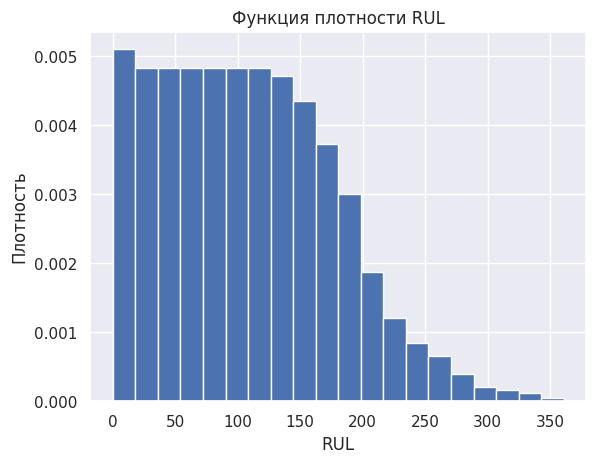

In [47]:
import seaborn as sns
sns.set()

trainRulDataset['RUL'].hist(density=True, bins=20)
plt.xlabel('RUL')
plt.ylabel('Плотность')
plt.title('Функция плотности RUL')

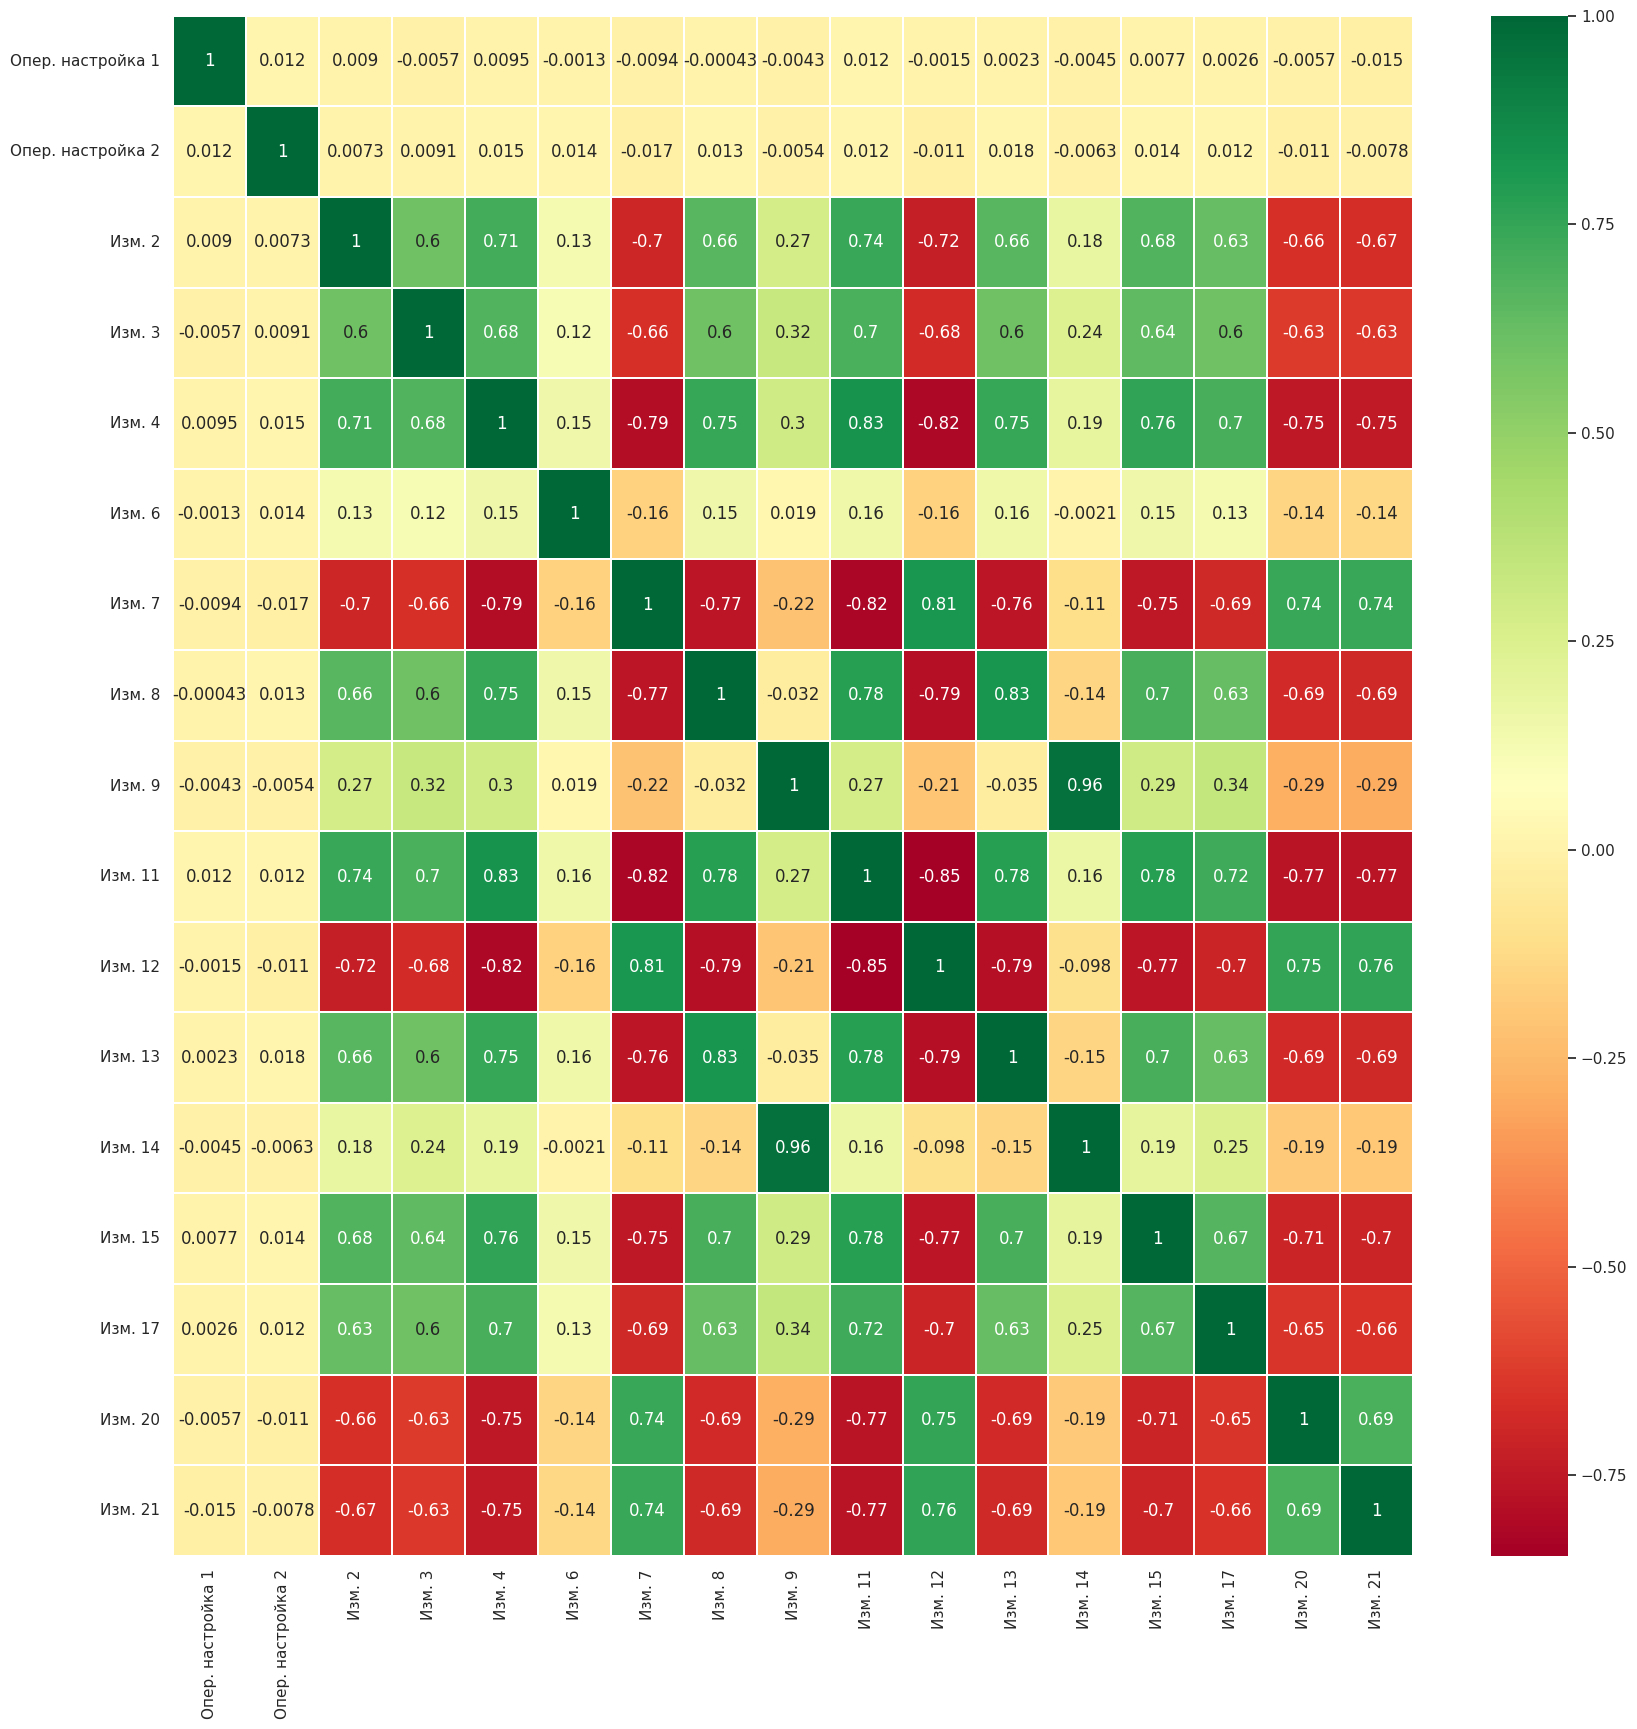

In [121]:
sns.heatmap(trainDatasetCopy.drop(columns=['Номер изделия', 'Время в циклах']).corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

Приведём данные к нужному виду:

In [48]:
defaultWindow = 10
defaultShift = 1
defaultTestWindow = 10

processedTrainDataset = None
processedTestDataset = None
processedTrainRulDataset = None
rulDatasets = None
testWindowList = None

trainedModel = []
predictedRulDatasets = []
rmseList = []
maeList = []
r2_scoreList = []
histories = []
train_times = []
inference_times = []

In [50]:
trainDatasetUnique = len(trainDatasetCopy['Номер изделия'].unique())
testDatasetUnique = len(testDatasetCopy['Номер изделия'].unique())

In [51]:
display(trainDatasetUnique)
display(testDatasetUnique)

100

100

In [55]:
temp1 = []
temp2 = []
for j in range(1, trainDatasetUnique+1):
    tempTrainDataset = trainDatasetCopy[trainDatasetCopy['Номер изделия'] == j].drop(columns = ['Номер изделия']).values

    window_size = min(len(tempTrainDataset), defaultWindow)

    tempTrainRulDataset = trainRulDataset[trainRulDataset['Номер изделия'] == j].drop(columns = ['Номер изделия']).values

    tempTrainDataset, tempTrainRulDataset = processTrainingData(tempTrainDataset, tempTrainRulDataset, window = window_size, shift = defaultShift)

    temp1.append(tempTrainDataset)
    temp2.append(tempTrainRulDataset)

processedTrainDataset = np.concatenate(temp1)
processedTrainRulDataset = np.concatenate(temp2)

In [60]:
temp1 = []
temp2 = []
for j in range(1, testDatasetUnique+1):
    tempTestDataset = testDatasetCopy[testDatasetCopy['Номер изделия'] == j].drop(columns = ['Номер изделия']).values

    window_size = min(len(tempTestDataset), defaultWindow)

    tempTestDataset, testWindow = processTestingData(tempTestDataset, window = window_size, shift = defaultShift, testWindow = defaultTestWindow)

    temp1.append(tempTestDataset)
    temp2.append(testWindow)

processedTestDataset = np.concatenate(temp1)
testWindowList = temp2
rulDataset = expectedRulDatasetCopy["Expected RUL"].values

Посмотрим на размерности данных:

In [62]:
print("Train Dataset Shape: ", processedTrainDataset.shape)
print("Train RUL Dataset Shape: ", processedTrainRulDataset.shape)
print("Test Dataset Shape: ", processedTestDataset.shape)
print("Expected RUL Shape: ", rulDataset.shape)
print("\n")

Train Dataset Shape:  (19731, 10, 18)
Train RUL Dataset Shape:  (19731,)
Test Dataset Shape:  (1000, 10, 18)
Expected RUL Shape:  (100,)




## 5. Построение моделей, эксперименты, замер метрик

In [63]:
import time

#### Константное предсказание

In [64]:
from sklearn.dummy import DummyRegressor

In [65]:
model = DummyRegressor()
model.fit(processedTrainDataset, processedTrainRulDataset)
trainedModel.append(model)

In [66]:
predictedRul = trainedModel[0].predict(processedTestDataset).reshape(-1)
predictedRul = np.split(predictedRul, np.cumsum(testWindowList)[:-1])
predictedRul = [np.average(ruls, weights = np.repeat(1/testWindow, testWindow)) for ruls, testWindow in zip(predictedRul, testWindowList)]

predictedRulDatasets.append(predictedRul)

In [69]:
print("For Constant")
print("Root Mean Square Error:", np.sqrt(mse(rulDataset, predictedRulDatasets[0])))
print('Mean Absolute Error:', mae(rulDataset, predictedRulDatasets[0]))
print('R^2:', r2_score(rulDataset, predictedRulDatasets[0]))
print("\n")
rmseList.append(np.sqrt(mse(rulDataset, predictedRulDatasets[0])))
maeList.append(mae(rulDataset, predictedRulDatasets[0]))
r2_scoreList.append(r2_score(rulDataset, predictedRulDatasets[0]))
train_times.append(1e-2)
inference_times.append(1e-3)

For Constant
Root Mean Square Error: 50.12137905438995
Mean Absolute Error: 39.27544473164056
R^2: -0.4547436808858296




#### 5.2. Ridge-регрессия

In [70]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold

In [71]:
X_train = processedTrainDataset.reshape(processedTrainDataset.shape[0], -1)
y_train = processedTrainRulDataset
X_test = processedTestDataset.reshape(processedTestDataset.shape[0], -1)
y_test = rulDataset

In [72]:
start = time.time()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=52)
model = RidgeCV(alphas=np.arange(0.1, 1, 0.1), cv=cv, scoring='neg_mean_absolute_error')
model.fit(X_train, y_train)
time_for_training = time.time() - start
trainedModel.append(model)
histories.append([])
train_times.append(time_for_training)

In [73]:
predictedRul = trainedModel[-1].predict(X_test).reshape(-1)
predictedRul = np.split(predictedRul, np.cumsum(testWindowList)[:-1])
predictedRul = [np.average(ruls, weights = np.repeat(1/testWindow, testWindow)) for ruls, testWindow in zip(predictedRul, testWindowList)]

predictedRulDatasets.append(predictedRul)

In [74]:
perfs = []
for _ in range(10):
    start = time.time()
    trainedModel[-1].predict(X_test)
    perfs.append(time.time() - start)
inference_times.append(np.mean(perfs))

In [75]:
print("For Linear")
print("Root Mean Square Error:", np.sqrt(mse(y_test, predictedRulDatasets[-1])))
print('Mean Absolute Error:', mae(y_test, predictedRulDatasets[-1]))
print('R^2:', r2_score(y_test, predictedRulDatasets[-1]))
print("\n")
rmseList.append(np.sqrt(mse(y_test, predictedRulDatasets[-1])))
maeList.append(mae(y_test, predictedRulDatasets[-1]))
r2_scoreList.append(r2_score(y_test, predictedRulDatasets[-1]))

For Linear
Root Mean Square Error: 32.67874512254414
Mean Absolute Error: 27.665349969559493
R^2: 0.3815975550300945




#### 5.3. GBDT (XGBoost в нашем случае)

In [76]:
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split

In [77]:
train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.1)
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

def objective(trial):
    param = {
      "verbosity": 0,
      'objective': 'reg:pseudohubererror',
      'eta': trial.suggest_float("eta", 1e-8, 1.0, log=True),
      'num_boosting_rounds': trial.suggest_int("num_boosting_rounds", 100, 1000)
    }
    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    return mae(valid_y, preds)

start = time.time()
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=600)
trial = study.best_trial
X_train_new = processedTrainDataset
model = xgb.XGBRegressor(learning_rate=trial.params['eta'], 
                         num_boosting_rounds=trial.params['num_boosting_rounds'])
model = model.fit(X_train, y_train)
train_times.append(time.time() - start)
trainedModel.append(model)
histories.append([])

predictedRul = trainedModel[-1].predict(X_test).reshape(-1)
predictedRul = np.split(predictedRul, np.cumsum(testWindowList)[:-1])
predictedRul = [np.average(ruls, weights = np.repeat(1/testWindow, testWindow)) for ruls, testWindow in zip(predictedRul, testWindowList)]

predictedRulDatasets.append(predictedRul)

[I 2024-06-20 17:03:36,339] A new study created in memory with name: no-name-e6f351dd-5032-4287-be27-92d391563723
[I 2024-06-20 17:03:37,373] Trial 0 finished with value: 27.82479999535231 and parameters: {'eta': 0.10147373889514377, 'num_boosting_rounds': 257}. Best is trial 0 with value: 27.82479999535231.
[I 2024-06-20 17:03:38,232] Trial 1 finished with value: 38.28084130423651 and parameters: {'eta': 0.11305930592997364, 'num_boosting_rounds': 765}. Best is trial 0 with value: 27.82479999535231.
[I 2024-06-20 17:03:38,683] Trial 2 finished with value: 103.48719932070982 and parameters: {'eta': 1.1967655327867378e-05, 'num_boosting_rounds': 877}. Best is trial 0 with value: 27.82479999535231.
[I 2024-06-20 17:03:39,312] Trial 3 finished with value: 104.19251001768924 and parameters: {'eta': 1.0889363368215681e-06, 'num_boosting_rounds': 505}. Best is trial 0 with value: 27.82479999535231.
[I 2024-06-20 17:03:39,789] Trial 4 finished with value: 922.003003318863 and parameters: {'et

In [78]:
print("For XGBoost")
print("Root Mean Square Error:", np.sqrt(mse(y_test, predictedRulDatasets[-1])))
print('Mean Absolute Error:', mae(y_test, predictedRulDatasets[-1]))
print('R^2:', r2_score(y_test, predictedRulDatasets[-1]))
print("\n")
rmseList.append(np.sqrt(mse(y_test, predictedRulDatasets[-1])))
maeList.append(mae(y_test, predictedRulDatasets[-1]))
r2_scoreList.append(r2_score(y_test, predictedRulDatasets[-1]))

For XGBoost
Root Mean Square Error: 27.607254502936776
Mean Absolute Error: 21.745485581159592
R^2: 0.5586461761849748




In [79]:
perfs = []
for _ in range(10):
    start = time.time()
    trainedModel[-1].predict(X_test)
    perfs.append(time.time() - start)
inference_times.append(np.mean(perfs))

#### 5.4. LSTM

In [84]:
model = createModel(processedTrainDataset.shape)
start = time.time()
history = model.fit(processedTrainDataset, 
                    processedTrainRulDataset, 
                    epochs=100, validation_split=0.2, batch_size=128, verbose=1)
train_times.append(time.time() - start)
print("\n")
trainedModel.append(model)
histories.append(history)

Epoch 1/100
124/124 [==============================] - 8s 16ms/step - loss: 12912.2178 - val_loss: 16832.5684
Epoch 2/100
124/124 [==============================] - 1s 7ms/step - loss: 11916.0986 - val_loss: 15944.3857
Epoch 3/100
124/124 [==============================] - 1s 7ms/step - loss: 11193.3174 - val_loss: 15146.7139
Epoch 4/100
124/124 [==============================] - 1s 8ms/step - loss: 10536.3125 - val_loss: 14409.9209
Epoch 5/100
124/124 [==============================] - 1s 7ms/step - loss: 9931.3750 - val_loss: 13722.9951
Epoch 6/100
124/124 [==============================] - 1s 7ms/step - loss: 9371.6885 - val_loss: 13082.5254
Epoch 7/100
124/124 [==============================] - 1s 7ms/step - loss: 8853.9004 - val_loss: 12485.6396
Epoch 8/100
124/124 [==============================] - 1s 7ms/step - loss: 8375.1514 - val_loss: 11927.6113
Epoch 9/100
124/124 [==============================] - 1s 7ms/step - loss: 7932.4170 - val_loss: 11409.7607
Epoch 10/100
124/124 [=

## Individual Model Testing

In [85]:
predictedRul = trainedModel[-1].predict(processedTestDataset).reshape(-1)
predictedRul = np.split(predictedRul, np.cumsum(testWindowList)[:-1])
predictedRul = [np.average(ruls, weights = np.repeat(1/testWindow, testWindow)) for ruls, testWindow in zip(predictedRul, testWindowList)]

predictedRulDatasets.append(predictedRul)

32/32 [==============================] - 1s 3ms/step


In [86]:
perfs = []
for _ in range(10):
    start = time.time()
    trainedModel[-1].predict(processedTestDataset)
    perfs.append(time.time() - start)
inference_times.append(np.mean(perfs))

32/32 [==============================] - 0s 3ms/step


In [87]:
print("For LSTM")
print("Root Mean Square Error:", np.sqrt(mse(rulDataset, predictedRulDatasets[-1])))
print('Mean Absolute Error:', mae(rulDataset, predictedRulDatasets[-1]))
print('R^2:', r2_score(rulDataset, predictedRulDatasets[-1]))
print("\n")
rmseList.append(np.sqrt(mse(rulDataset, predictedRulDatasets[-1])))
maeList.append(mae(rulDataset, predictedRulDatasets[-1]))
r2_scoreList.append(r2_score(rulDataset, predictedRulDatasets[-1]))

For LSTM
Root Mean Square Error: 29.474562987551064
Mean Absolute Error: 22.012684510946272
R^2: 0.4969221397451693




#### 5.5. Визуализация экспериментов

In [88]:
algos = ['Константное предсказание', 'Линейная модель', 'Градиентный бустинг', 'LSTM']
colors = ['green', 'blue', 'orange', 'violet']
metrics = ['RMSE', 'MAE', 'R^2', 'Время обучения модели', 'Время, потраченное на подсчет результата (инференс)']

In [89]:
data = {metrics[i]: j for i, j in enumerate([rmseList, maeList, r2_scoreList, train_times, inference_times])}
results = pd.DataFrame(data, index=algos)

In [90]:
import seaborn as sns

sns.set()

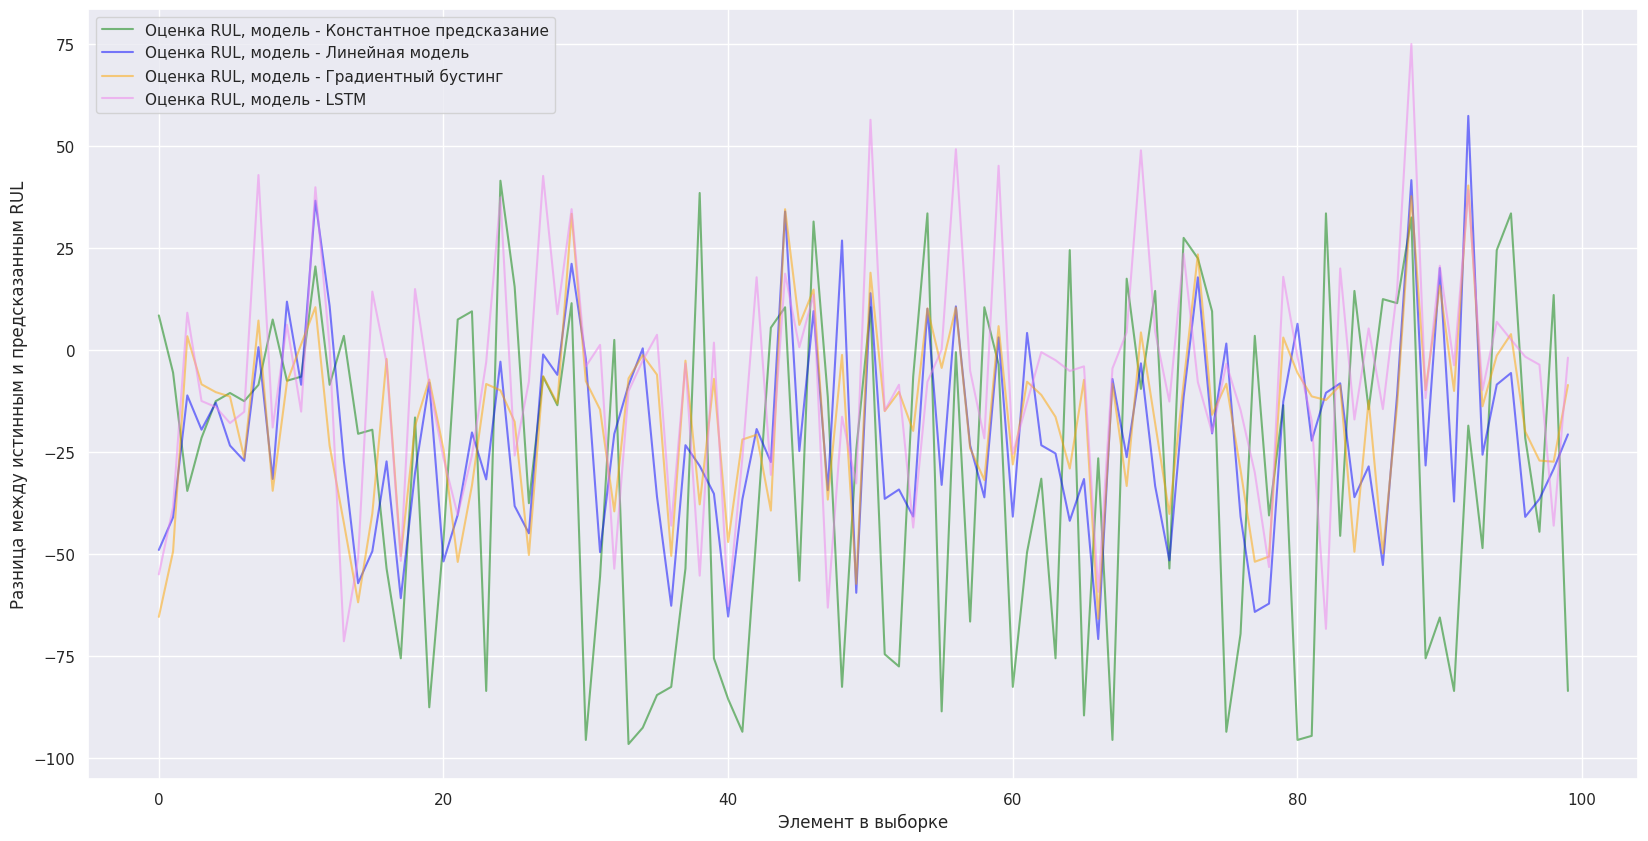

In [94]:
plt.figure(figsize=(20, 10))

for i in range(4):
    plt.plot(rulDataset - predictedRulDatasets[i], label = f"Оценка RUL, модель - {algos[i]}", color=colors[i], alpha=0.5)
plt.legend(loc='upper left')
plt.xlabel('Элемент в выборке')
plt.ylabel('Разница между истинным и предсказанным RUL')
plt.show()

Результаты без выбора признаков

In [95]:
results

,RMSE,MAE,R^2,Время обучения модели,"Время, потраченное на подсчет результата (инференс)"
Константное предсказание,50.121379,39.275445,-0.454744,0.010000,0.001000
Линейная модель,32.678745,27.665350,0.381598,27.665009,0.001341
Градиентный бустинг,27.607255,21.745486,0.558646,93.603438,0.002690
LSTM,29.474563,22.012685,0.496922,97.144886,0.158847


## 6. Отбор признаков

Работаем с лучшей моделью

In [96]:
[type(i) for i in trainedModel]

[sklearn.dummy.DummyRegressor,
 sklearn.linear_model._ridge.RidgeCV,
 xgboost.sklearn.XGBRegressor,
 keras.engine.sequential.Sequential]

In [97]:
gbdt = trainedModel[-2]

Text(0.5, 1.0, 'Распределение важности признаков')

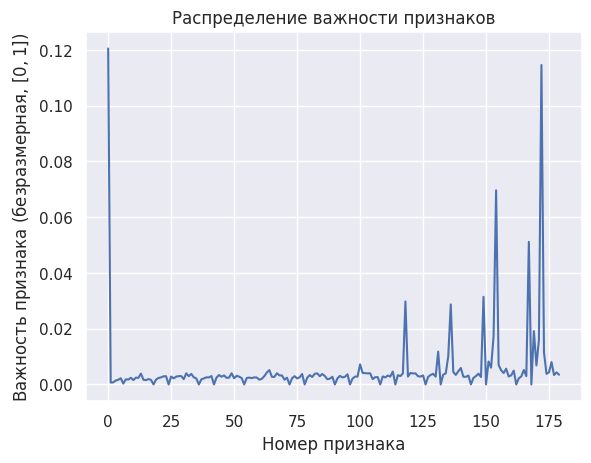

In [98]:
plt.plot(gbdt.feature_importances_)
plt.xlabel('Номер признака')
plt.ylabel('Важность признака (безразмерная, $[0, 1]$)')
plt.title('Распределение важности признаков')

In [99]:
best_indices = np.argsort(gbdt.feature_importances_)[::-1]

In [100]:
gbdt.feature_importances_[best_indices[:10]]

array([0.12056373, 0.11463378, 0.06965503, 0.05116862, 0.03144127,
       0.02978731, 0.02871042, 0.01914894, 0.01729433, 0.01599553],
      dtype=float32)

In [101]:
prod_indices = best_indices[:30]

In [102]:
gbdt.feature_importances_[prod_indices]

array([0.12056373, 0.11463378, 0.06965503, 0.05116862, 0.03144127,
       0.02978731, 0.02871042, 0.01914894, 0.01729433, 0.01599553,
       0.01177193, 0.0115787 , 0.010029  , 0.00824101, 0.0080393 ,
       0.00720857, 0.00700948, 0.0068188 , 0.00601447, 0.00589933,
       0.00565113, 0.00518141, 0.00514708, 0.00507583, 0.00496042,
       0.0047403 , 0.00462591, 0.00446545, 0.00433905, 0.00432433],
      dtype=float32)

In [103]:
prod_indices

array([  0, 172, 154, 167, 149, 118, 136, 169, 153, 171, 131, 173, 135,
       151, 176, 100, 155, 170, 152, 140, 158, 165,  64, 156, 161, 139,
       113, 137, 175, 178])

Text(0.5, 1.0, 'Распределение важности признаков')

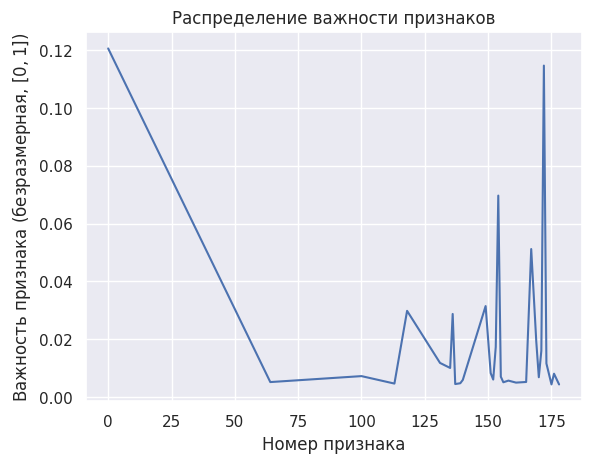

In [104]:
plt.plot(np.sort(prod_indices), gbdt.feature_importances_[np.sort(prod_indices)])
plt.xlabel('Номер признака')
plt.ylabel('Важность признака (безразмерная, $[0, 1]$)')
plt.title('Распределение важности признаков')

In [105]:
X_train.shape

(19731, 180)

In [106]:
X_train.shape

(19731, 180)

In [107]:
X_train_prod = X_train[:, prod_indices]
X_test_prod = X_test[:, prod_indices]

In [108]:
X_train_prod.shape

(19731, 30)

In [109]:
train_x, valid_x, train_y, valid_y = train_test_split(X_train_prod, y_train, test_size=0.1)
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

def objective(trial):
    param = {
      "verbosity": 0,
      'objective': 'reg:pseudohubererror',
      'eta': trial.suggest_float("eta", 1e-8, 1.0, log=True),
      'num_boosting_rounds': trial.suggest_int("num_boosting_rounds", 100, 1000)
    }
    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    return mae(valid_y, preds)

start = time.time()
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=600)
trial = study.best_trial
X_train_new = X_train_prod
model = xgb.XGBRegressor(learning_rate=trial.params['eta'], num_boosting_rounds=trial.params['num_boosting_rounds'])
model = model.fit(X_train_prod, y_train)
train_times.append(time.time() - start)
trainedModel.append(model)
histories.append([])

[I 2024-06-20 17:08:38,202] A new study created in memory with name: no-name-8f86be1f-ee1f-4602-9dfd-8f42f5ea25a8
[I 2024-06-20 17:08:38,432] Trial 0 finished with value: 31.174071118763997 and parameters: {'eta': 0.13531658013917952, 'num_boosting_rounds': 872}. Best is trial 0 with value: 31.174071118763997.
[I 2024-06-20 17:08:38,542] Trial 1 finished with value: 99.78884462331324 and parameters: {'eta': 4.506763775235421e-05, 'num_boosting_rounds': 335}. Best is trial 0 with value: 31.174071118763997.
[I 2024-06-20 17:08:38,649] Trial 2 finished with value: 102.27603766974345 and parameters: {'eta': 5.701756746044052e-06, 'num_boosting_rounds': 277}. Best is trial 0 with value: 31.174071118763997.
[I 2024-06-20 17:08:38,810] Trial 3 finished with value: 63.80394765408568 and parameters: {'eta': 0.001468429420426222, 'num_boosting_rounds': 663}. Best is trial 0 with value: 31.174071118763997.
[I 2024-06-20 17:08:38,917] Trial 4 finished with value: 102.61533987561378 and parameters:

TypeError: 'int' object is not iterable

In [111]:
predictedRul = trainedModel[-1].predict(X_test_prod).reshape(-1)
predictedRul = np.split(predictedRul, np.cumsum(testWindowList)[:-1])
predictedRul = [np.average(ruls, weights = np.repeat(1/testWindow, testWindow)) for ruls, testWindow in zip(predictedRul, testWindowList)]

predictedRulDatasets.append(predictedRul)

In [112]:
print("For XGBoost + features")
print("Root Mean Square Error:", np.sqrt(mse(y_test, predictedRulDatasets[-1])))
print('Mean Absolute Error:', mae(y_test, predictedRulDatasets[-1]))
print('R^2:', r2_score(y_test, predictedRulDatasets[-1]))
print("\n")
rmseList.append(np.sqrt(mse(y_test, predictedRulDatasets[-1])))
maeList.append(mae(y_test, predictedRulDatasets[-1]))
r2_scoreList.append(r2_score(y_test, predictedRulDatasets[-1]))

For XGBoost + features
Root Mean Square Error: 28.149900926147286
Mean Absolute Error: 22.026110994338993
R^2: 0.5411252116825103




In [113]:
perfs = []
for _ in range(10):
    start = time.time()
    trainedModel[-1].predict(X_test_prod)
    perfs.append(time.time() - start)
inference_times.append(np.mean(perfs))

#### Визуализация сравнительных результатов с получившейся моделью

In [114]:
algos = ['Константное предсказание', 'Линейная модель', 'Градиентный бустинг', 'LSTM', 'Градиентный бустинг + подбор признаков']
colors = ['green', 'blue', 'orange', 'violet', 'red']
metrics = ['RMSE', 'MAE', 'R^2', 'Время обучения модели', 'Время, потраченное на подсчет результата (инференс)']

In [115]:
data = {metrics[i]: j for i, j in enumerate([rmseList, maeList, r2_scoreList, train_times, inference_times])}
results = pd.DataFrame(data, index=algos)

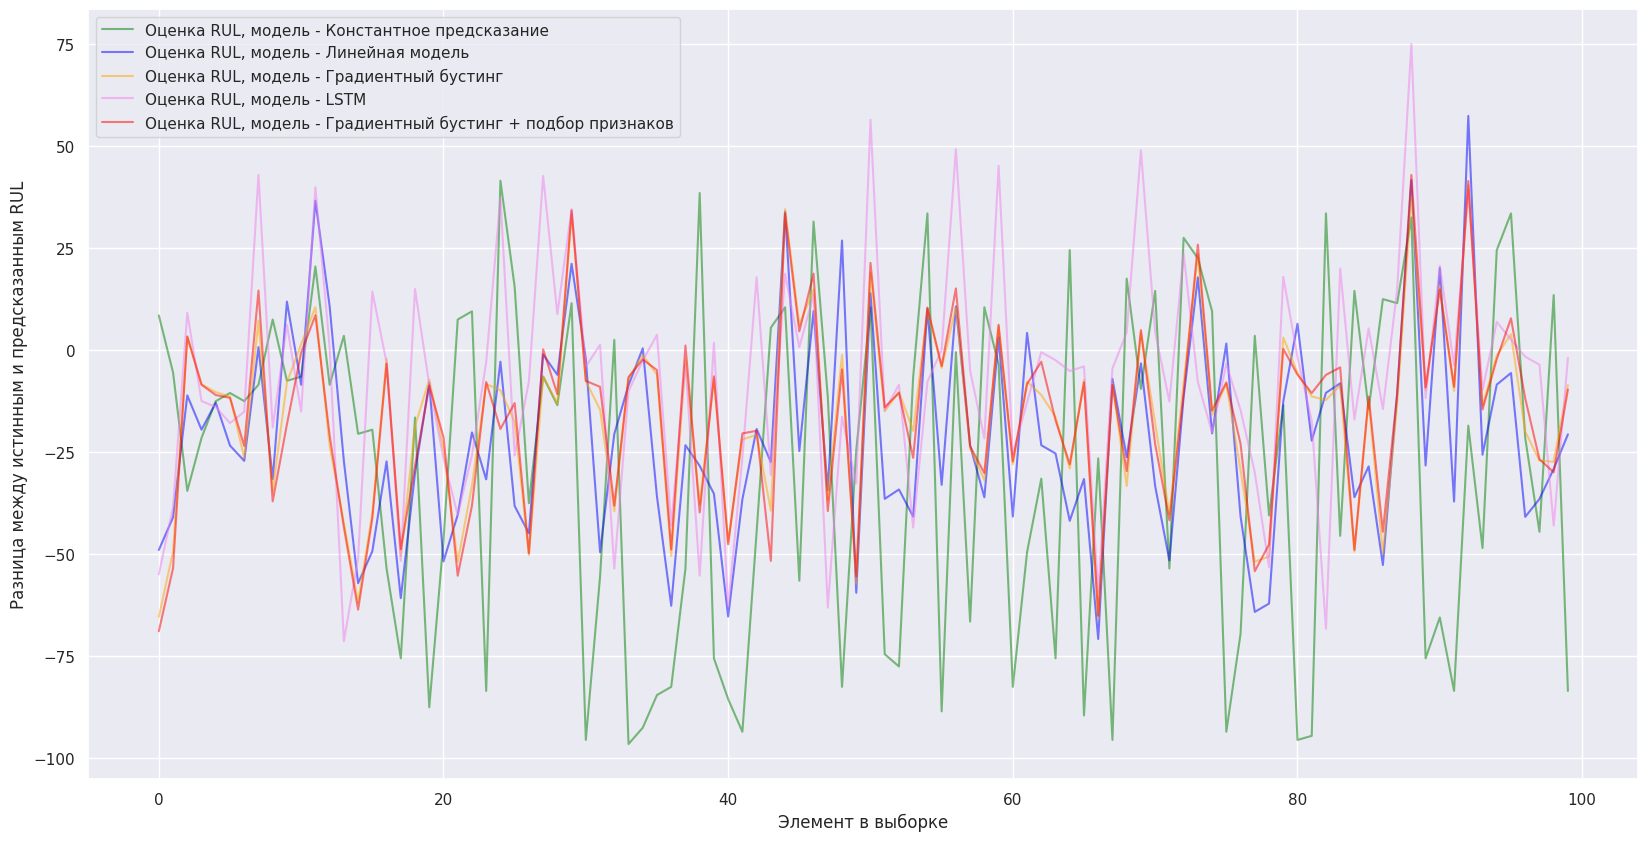

In [118]:
plt.figure(figsize=(20, 10))

for i in range(5):
    plt.plot(rulDataset - predictedRulDatasets[i], label = f"Оценка RUL, модель - {algos[i]}", color=colors[i], alpha=0.5)
plt.legend(loc='upper left')
plt.xlabel('Элемент в выборке')
plt.ylabel('Разница между истинным и предсказанным RUL')
plt.show()

In [119]:
results

,RMSE,MAE,R^2,Время обучения модели,"Время, потраченное на подсчет результата (инференс)"
Константное предсказание,50.121379,39.275445,-0.454744,0.010000,0.001000
Линейная модель,32.678745,27.665350,0.381598,27.665009,0.001341
Градиентный бустинг,27.607255,21.745486,0.558646,93.603438,0.002690
LSTM,29.474563,22.012685,0.496922,97.144886,0.158847
Градиентный бустинг + подбор признаков,28.149901,22.026111,0.541125,24.763659,0.002143


## Сохраняем итоговую (продакшен) модель - бустинг с отобранными признаками

In [120]:
trainedModel[-1].save_model('best_model.model')